In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from hmmlearn import hmm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

C:\Users\Sonia\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

In [2]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [3]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders']], on='customer_db_id', how='left')
df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_created_month'] = df_ord.order_created_datetime.dt.month
df_ord['order_created_weekday'] = df_ord.order_created_datetime.dt.weekday
df_ord['order_created_year'] = df_ord.order_created_datetime.dt.year

In [4]:
df_items = pd.read_csv('../data/input/items.csv')
df_items = df_items.groupby('order_id').agg({'quantity': 'sum', 'product_type': 'nunique'}).reset_index()
df_items = df_items.rename(columns={'product_type': 'num_unique_products'})
df_ord = df_ord.merge(df_items, on='order_id', how='left')

# Filter data

In [5]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()

# days
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7
df_comp['weeks_since_last_comp'] = df_comp.days_since_last_comp // 7

# frequency
df_comp['frequency_exp_median'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_median_diff'] = df_comp.days_since_last_comp - df_comp.frequency_exp_median

# revenue
df_comp['revenue_brutto'] = df_comp.revenue + df_comp.voucher_value
df_comp['last_order_revenue_brutto'] = df_comp.groupby('customer_db_id')['revenue_brutto'].shift(1)
df_comp['last_revenue_brutto_diff'] = df_comp.revenue_brutto - df_comp.last_order_revenue_brutto

df_comp = df_comp.drop(['next_order_date', 'last_order_date', 'last_order_revenue_brutto'], axis=1)

In [6]:
# frequencies per each cluster, calcualted based on all customers
cluster_frequencies = df_comp.groupby('cluster')['days_until_next_comp'].median().reset_index()
cluster_frequencies = cluster_frequencies.rename(columns={'days_until_next_comp': 'cluster_median_freq'})
df_comp = df_comp.merge(cluster_frequencies, on='cluster', how='left')

In [7]:
df_comp.to_csv('../data/old/comp_orders.csv', index=False)

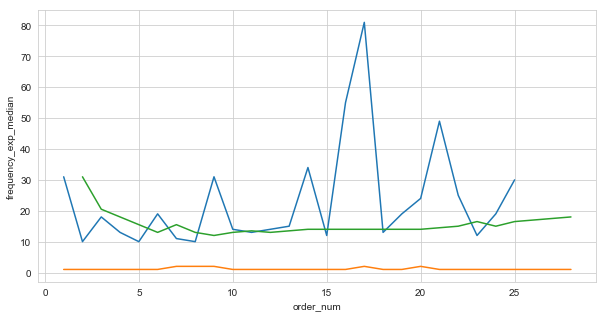

In [8]:
fig, ax= plt.subplots(figsize=(10,5))
sns.lineplot(data=df_comp.loc[df_comp.customer_db_id == '586c07be447709cd6c8b46b5'],
             x='order_num', y='days_until_next_comp', ax=ax)
sns.lineplot(data=df_comp.loc[df_comp.customer_db_id == '586c07be447709cd6c8b46b5'],
             x='order_num', y='quantity', ax=ax)
sns.lineplot(data=df_comp.loc[df_comp.customer_db_id == '586c07be447709cd6c8b46b5'],
             x='order_num', y='frequency_exp_median', ax=ax)

# Create Features



# Dataset

In [66]:
num_completed_orders = 3

In [67]:
cust_ids_excl = df_comp.loc[(df_comp.city != 'London') |
                            (df_comp.days_until_next_comp > 150) | (df_comp.days_until_next_comp == 0) |
                            (df_comp.days_since_last_comp > 150) | (df_comp.days_since_last_comp == 0) |
                            (df_comp.revenue > 50) | (df_comp.corporate) |
                            (df_comp.completed_orders < num_completed_orders)].customer_db_id.unique().tolist()
print(len(cust_ids_excl), '/', df_comp.customer_db_id.nunique())

28620 / 30175


In [68]:
df_city = df_comp.loc[~(df_comp.customer_db_id.isin(cust_ids_excl))]
df_city = df_city.loc[df_city.order_comp_num < num_completed_orders]

In [71]:
sorted(df_city.order_comp_num.unique())

[0, 1, 2]

In [72]:
print('Num orders:', df_city.order_id.nunique())
print('Num customers:', df_city.customer_db_id.nunique())

Num orders: 4665
Num customers: 1555


# Create Features

In [83]:
df_last_order = df_city[df_city.order_comp_num == num_completed_orders-1]
df_unknown = df_last_order[df_last_order.completed_orders == num_completed_orders]
df_known = df_last_order[df_last_order.completed_orders > num_completed_orders]

In [84]:
print(df_known.shape)
print(df_unknown.shape)

(1034, 86)
(521, 86)


In [86]:
# df_pivot = df_city.set_index(['customer_db_id', 'order_comp_num']).unstack().swaplevel(axis=1)
# df_pivot.head()

# Baseline

In [97]:
df_known['predicted_days_until_next_comp'] = df_known.frequency_exp_median
metrics.euclidean_distances(df_known.predicted_days_until_next_comp.values.reshape(-1, 1), 
                            df_known.days_until_next_comp.values.reshape(-1, 1)).mean()

26.737918507682696

# EDA

In [15]:
df_city.revenue_brutto.describe()

count    4894.000000
mean       24.494533
std         9.080363
min         4.757964
25%        16.853410
50%        22.822300
75%        29.324801
max        79.239601
Name: revenue_brutto, dtype: float64

In [16]:
df_city.gender.value_counts()

male      3468
female    1341
Name: gender, dtype: int64

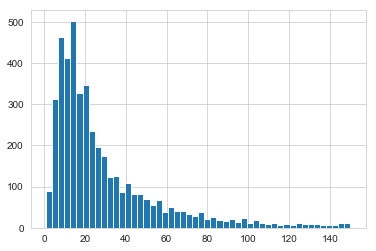

In [17]:
df_city.days_until_next_comp.hist(bins=50)

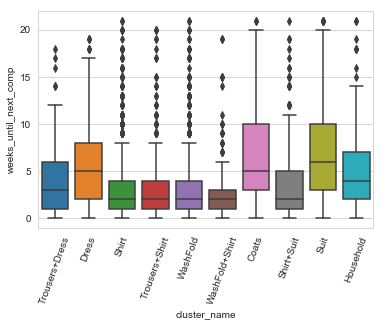

In [18]:
plt.xticks(rotation=70)
sns.categorical.boxplot(data=df_city, x='cluster_name', y='weeks_until_next_comp')

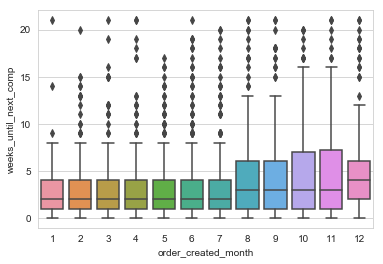

In [19]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_city.loc[df_city.order_created_year == 2017], x='order_created_month', y='weeks_until_next_comp')

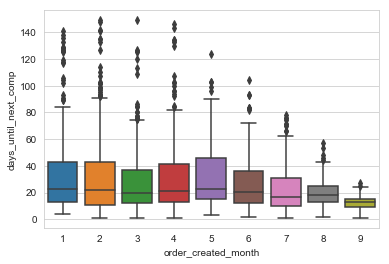

In [21]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_city.loc[df_city.order_created_year == 2018], x='order_created_month', y='days_until_next_comp')

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_known, x='order_created_weekday', y='weeks_until_next_comp')

In [ ]:
sns.categorical.boxplot(data=df_known, x='gender', y='weeks_until_next_comp')

In [ ]:
sns.categorical.boxplot(data=df_known, x='service_class', y='weeks_until_next_comp')

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=df_known, x='order_x', y='order_y', hue='weeks_until_next_comp', alpha=0.8, legend=False)

In [ ]:
# fig, ax = plt.subplots(figsize=(12,12))
sns.categorical.boxplot(data=df_known, x='voucher_channel', y='days_until_next_comp')

In [ ]:
sns.scatterplot(data=df_known.loc[df_known.voucher_value > 0], x='voucher_value', y='weeks_until_next_comp', alpha=0.5, legend=False)

In [ ]:

sns.boxplot(data=df_known, x='quantity', y='days_until_next_comp')

In [ ]:
df_known.corr()['weeks_until_next_comp'].sort_values()

In [ ]:
df_known.revenue_brutto.hist(bins=50)

In [ ]:
df_known.shape

# Predictions

In [ ]:
df_known.set_index(['customer_db_id', 'order_num']).unstack().swaplevel(axis=1)

In [ ]:
feats = ['gender', 'revenue_brutto', 'weeks_since_last_comp',
        'order_created_month'] + df_known.columns[-10:].tolist()
feats

In [ ]:
# features
df_feats = df_known[['weeks_until_next_comp'] + feats]

df_feats['gender'] = df_feats.gender.map({'male': -1, 'female': 1}).fillna(0)

In [ ]:
sns.heatmap(df_feats.corr())

In [ ]:
X = df_feats.iloc[:, 1:].values
y = df_feats.iloc[:, 0].values
n_classes =  df_feats.iloc[:, 0].nunique()
n_classes

In [ ]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y_norm = y.reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25, random_state=42)

In [ ]:
sns.distplot(y_test, bins=20)

In [ ]:
log_reg = linear_model.LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print('train', log_reg.score(X_train, y_train), 'test', log_reg.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_train, log_reg.predict(X_train).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))
acc = metrics.accuracy_score(y_test, log_reg.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
sns.distplot(log_reg.predict(X_test), bins=20)

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, log_reg.predict(X_test).reshape(-1,1)))
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
lin_reg = linear_model.LinearRegression().fit(X_train, y_train)
print('train', lin_reg.score(X_train, y_train), 'test', lin_reg.score(X_test, y_test)) 

In [ ]:
sns.distplot(lin_reg.predict(X_test), bins=20)

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, lin_reg.predict(X_test).round()))
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
sup = svm.SVC(class_weight='balanced', verbose=True, gamma='auto').fit(X_train, y_train)
print('train', sup.score(X_train, y_train), 'test', sup.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_test, sup.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=40).fit(X_train, y_train) 
neigh.score(X_test, y_test)
print('train', neigh.score(X_train, y_train), 'test', neigh.score(X_test, y_test))
acc = metrics.f1_score(y_test, neigh.predict(X_test), average='weighted')
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
frst = RandomForestClassifier(n_estimators=200, max_depth=4, class_weight='balanced').fit(X_train, y_train)
print('train', frst.score(X_train, y_train), 'test', frst.score(X_test, y_test))
acc = metrics.accuracy_score(y_test, frst.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=1, max_iter=1000, 
                    learning_rate_init=0.001, verbose=True, batch_size=1, alpha=0.9).fit(X_train, y_train)
print('train', mlp.score(X_train, y_train), 'test', mlp.score(X_test, y_test))
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)
acc = metrics.accuracy_score(y_test, mlp.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, mlp.predict(X_test).reshape(-1,1)))

In [ ]:
bys = linear_model.BayesianRidge().fit(X_train, y_train)
print('train', bys.score(X_train, y_train), 'test', bys.score(X_test, y_test))

In [ ]:
bys.predict(X_test)

In [ ]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")